In [12]:
import pandas as pd
import numpy as np
import plotly.express as px
from pyproj import Proj
from datetime import datetime
import json
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, matthews_corrcoef, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.model_selection import train_test_split
import sqlalchemy
from sklearn.manifold import t_sne
import seaborn as sns
import missingno
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Reading the log files

##### make sure that the folder contains only log files

In [2]:
rssi_folder_path = 'tamar'

files = os.listdir(rssi_folder_path)
dfs = []
for file in files:
    print(file)
    txt = open('tamar\\' + file,"r", encoding="utf-8").read()
    txt = txt.replace("}{", "}, {")
    data = txt.split(', ')
    j=[]
    for d in data:
        if(len(d)>0):
            j.append(json.loads(d))
    df = pd.DataFrame(j)
    dfs.append(df)
    
wifi_df = pd.concat(dfs)
print(wifi_df.shape)
wifi_df.head(2)

03ae308bd7102024.txt
2c0522a1c69b22bc.txt
87888aecf8b37f14.txt
d2e242e0a080f7e7.txt
ef3f50e69df5ed94.txt
(12938, 9)


,accuracy,altitude,longitude,latitude,rssi_by_bssid,imei,timestamp,room_id,roomId
0,17.721001,0.0,34.85598,32.072572,"{'10:13:31:c7:97:3d': -72, '12:13:31:c7:97:45'...",03ae308bd7102024,1585864152289,2.0,NaN
1,14.547000,0.0,34.85596,32.072604,"{'12:13:31:c7:97:45': -78, '10:13:31:c7:97:3d'...",03ae308bd7102024,1585864158290,2.0,NaN


In [3]:
#drop empty wifi scans
wifi_df = wifi_df[wifi_df['rssi_by_bssid'] !={}]

#drop sample outside rooms
wifi_df = wifi_df.dropna(subset=['room_id'])
wifi_df['room_id'] = wifi_df['room_id'].astype(int)

#drop bad samples in rooms 20 and 42
wifi_df = wifi_df[(wifi_df['room_id']>30)&(wifi_df['room_id']!=42)] 

#drop same timestamps
print("Shape before drop : " + str(wifi_df.shape))
wifi_df.drop_duplicates('timestamp',inplace=True)

print(wifi_df.shape)
wifi_df.head(2)

Shape before drop : (8340, 9)
(8334, 9)


,accuracy,altitude,longitude,latitude,rssi_by_bssid,imei,timestamp,room_id,roomId
53,4.30,107.664924,34.849293,32.081646,"{'40:9b:cd:ca:f1:7c': -52, '14:ae:db:36:68:6d'...",03ae308bd7102024,1585910576850,31,NaN
54,4.54,108.194274,34.849278,32.081649,"{'40:9b:cd:ca:f1:7c': -53, '00:68:eb:17:2d:35'...",03ae308bd7102024,1585910579913,31,NaN


In [4]:
print("Rooms for prediction : " + str(wifi_df.room_id.unique()))
print("Phones imeis : ")
imeis = list(wifi_df.imei.unique())
print(imeis)
print(files)

Rooms for prediction : [31 32 33 34 35 36 41 43 44 45 46]
Phones imeis : 
['03ae308bd7102024', '2c0522a1c69b22bc', '87888aecf8b37f14', 'd2e242e0a080f7e7', 'ef3f50e69df5ed94']
['03ae308bd7102024.txt', '2c0522a1c69b22bc.txt', '87888aecf8b37f14.txt', 'd2e242e0a080f7e7.txt', 'ef3f50e69df5ed94.txt']


### Create scans dataframe

In [5]:
wifi_df['rssi_by_bssid'] = wifi_df.apply(lambda x : pd.concat([pd.DataFrame([x['timestamp']]).rename(columns={0:1}), 
                                                     pd.DataFrame((x['rssi_by_bssid']).items()).set_index(0)],
                                                    axis=0).T ,axis=1)

scans_df = pd.concat(wifi_df['rssi_by_bssid'].tolist())
scans_df.rename(columns={0:'timestamp'}, inplace=True)
scans_df = pd.merge(scans_df,wifi_df[['room_id','imei','timestamp']], on='timestamp').set_index('timestamp')

print(scans_df.shape)
scans_df.head(2)

(8334, 198)


,40:9b:cd:ca:f1:7c,14:ae:db:36:68:6d,00:68:eb:17:2d:35,04:f0:21:41:db:76,14:ae:db:54:2c:f5,40:9b:cd:ca:56:68,10:be:f5:3c:29:f6,b4:ee:b4:fe:21:fb,ec:9a:74:98:3c:9d,00:b8:c2:50:4f:21,...,64:51:06:71:63:ee,78:32:1b:d6:05:20,8c:59:c3:bb:95:5c,a0:ab:1b:55:55:ee,12:13:31:c7:df:e3,10:5a:f7:1e:95:50,c4:12:f5:fd:ee:7c,60:e3:27:e8:3e:88,room_id,imei
timestamp,,,,,,,,,,,,,,,,,,,,,
1585910576850,-52.0,-59.0,-61.0,-78.0,-81.0,-87.0,-88.0,-90.0,-91.0,-92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,03ae308bd7102024
1585910579913,-53.0,-57.0,-54.0,-78.0,-82.0,-85.0,-86.0,NaN,-88.0,-92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,03ae308bd7102024


### Create output folder and figures

In [6]:
date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
path = date_time + '_output_folder'
os.mkdir(path) #new output folder in main dir

Number of WiFi scans per sample : 
count    8334.00000
mean       18.13067
std         7.31159
min         1.00000
25%        13.00000
50%        17.00000
75%        22.00000
max        53.00000
Name: n_scans, dtype: float64


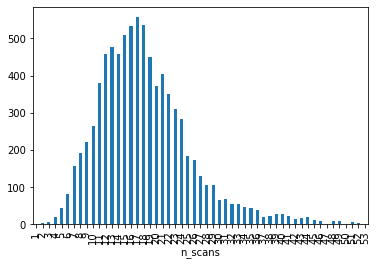

In [7]:
plt.figure()
#count only scans (not nan)
scans_df['n_scans'] = scans_df.apply(lambda x: x.count()-2, axis=1)  # (-2) for columns 'room_id' and 'imei' in scans_df

print('Number of WiFi scans per sample : ')
print(scans_df['n_scans'].describe())
scans_df.groupby('n_scans').size().plot.bar()
plt.savefig(path+"\\n_scans.jpg")

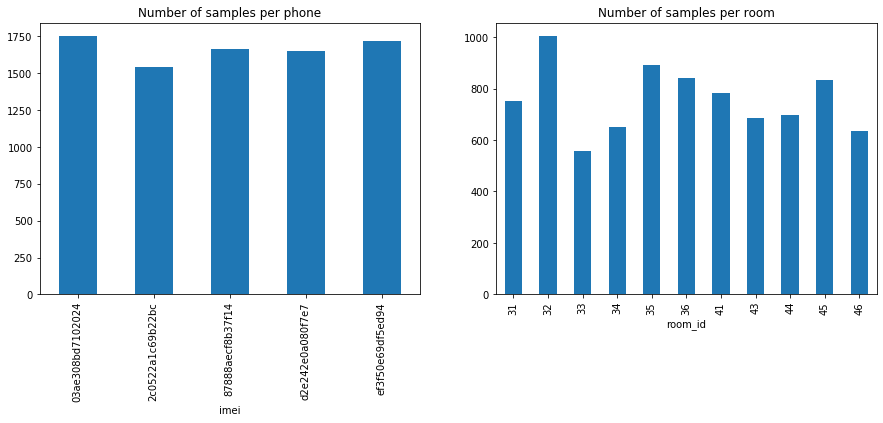

In [8]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title('Number of samples per phone')
scans_df.groupby('imei').size().plot.bar()
plt.subplot(1,2,2)
plt.title('Number of samples per room')
scans_df.groupby('room_id').size().plot.bar()
plt.savefig(path+"\\samples_per_phone_and_room.jpg")

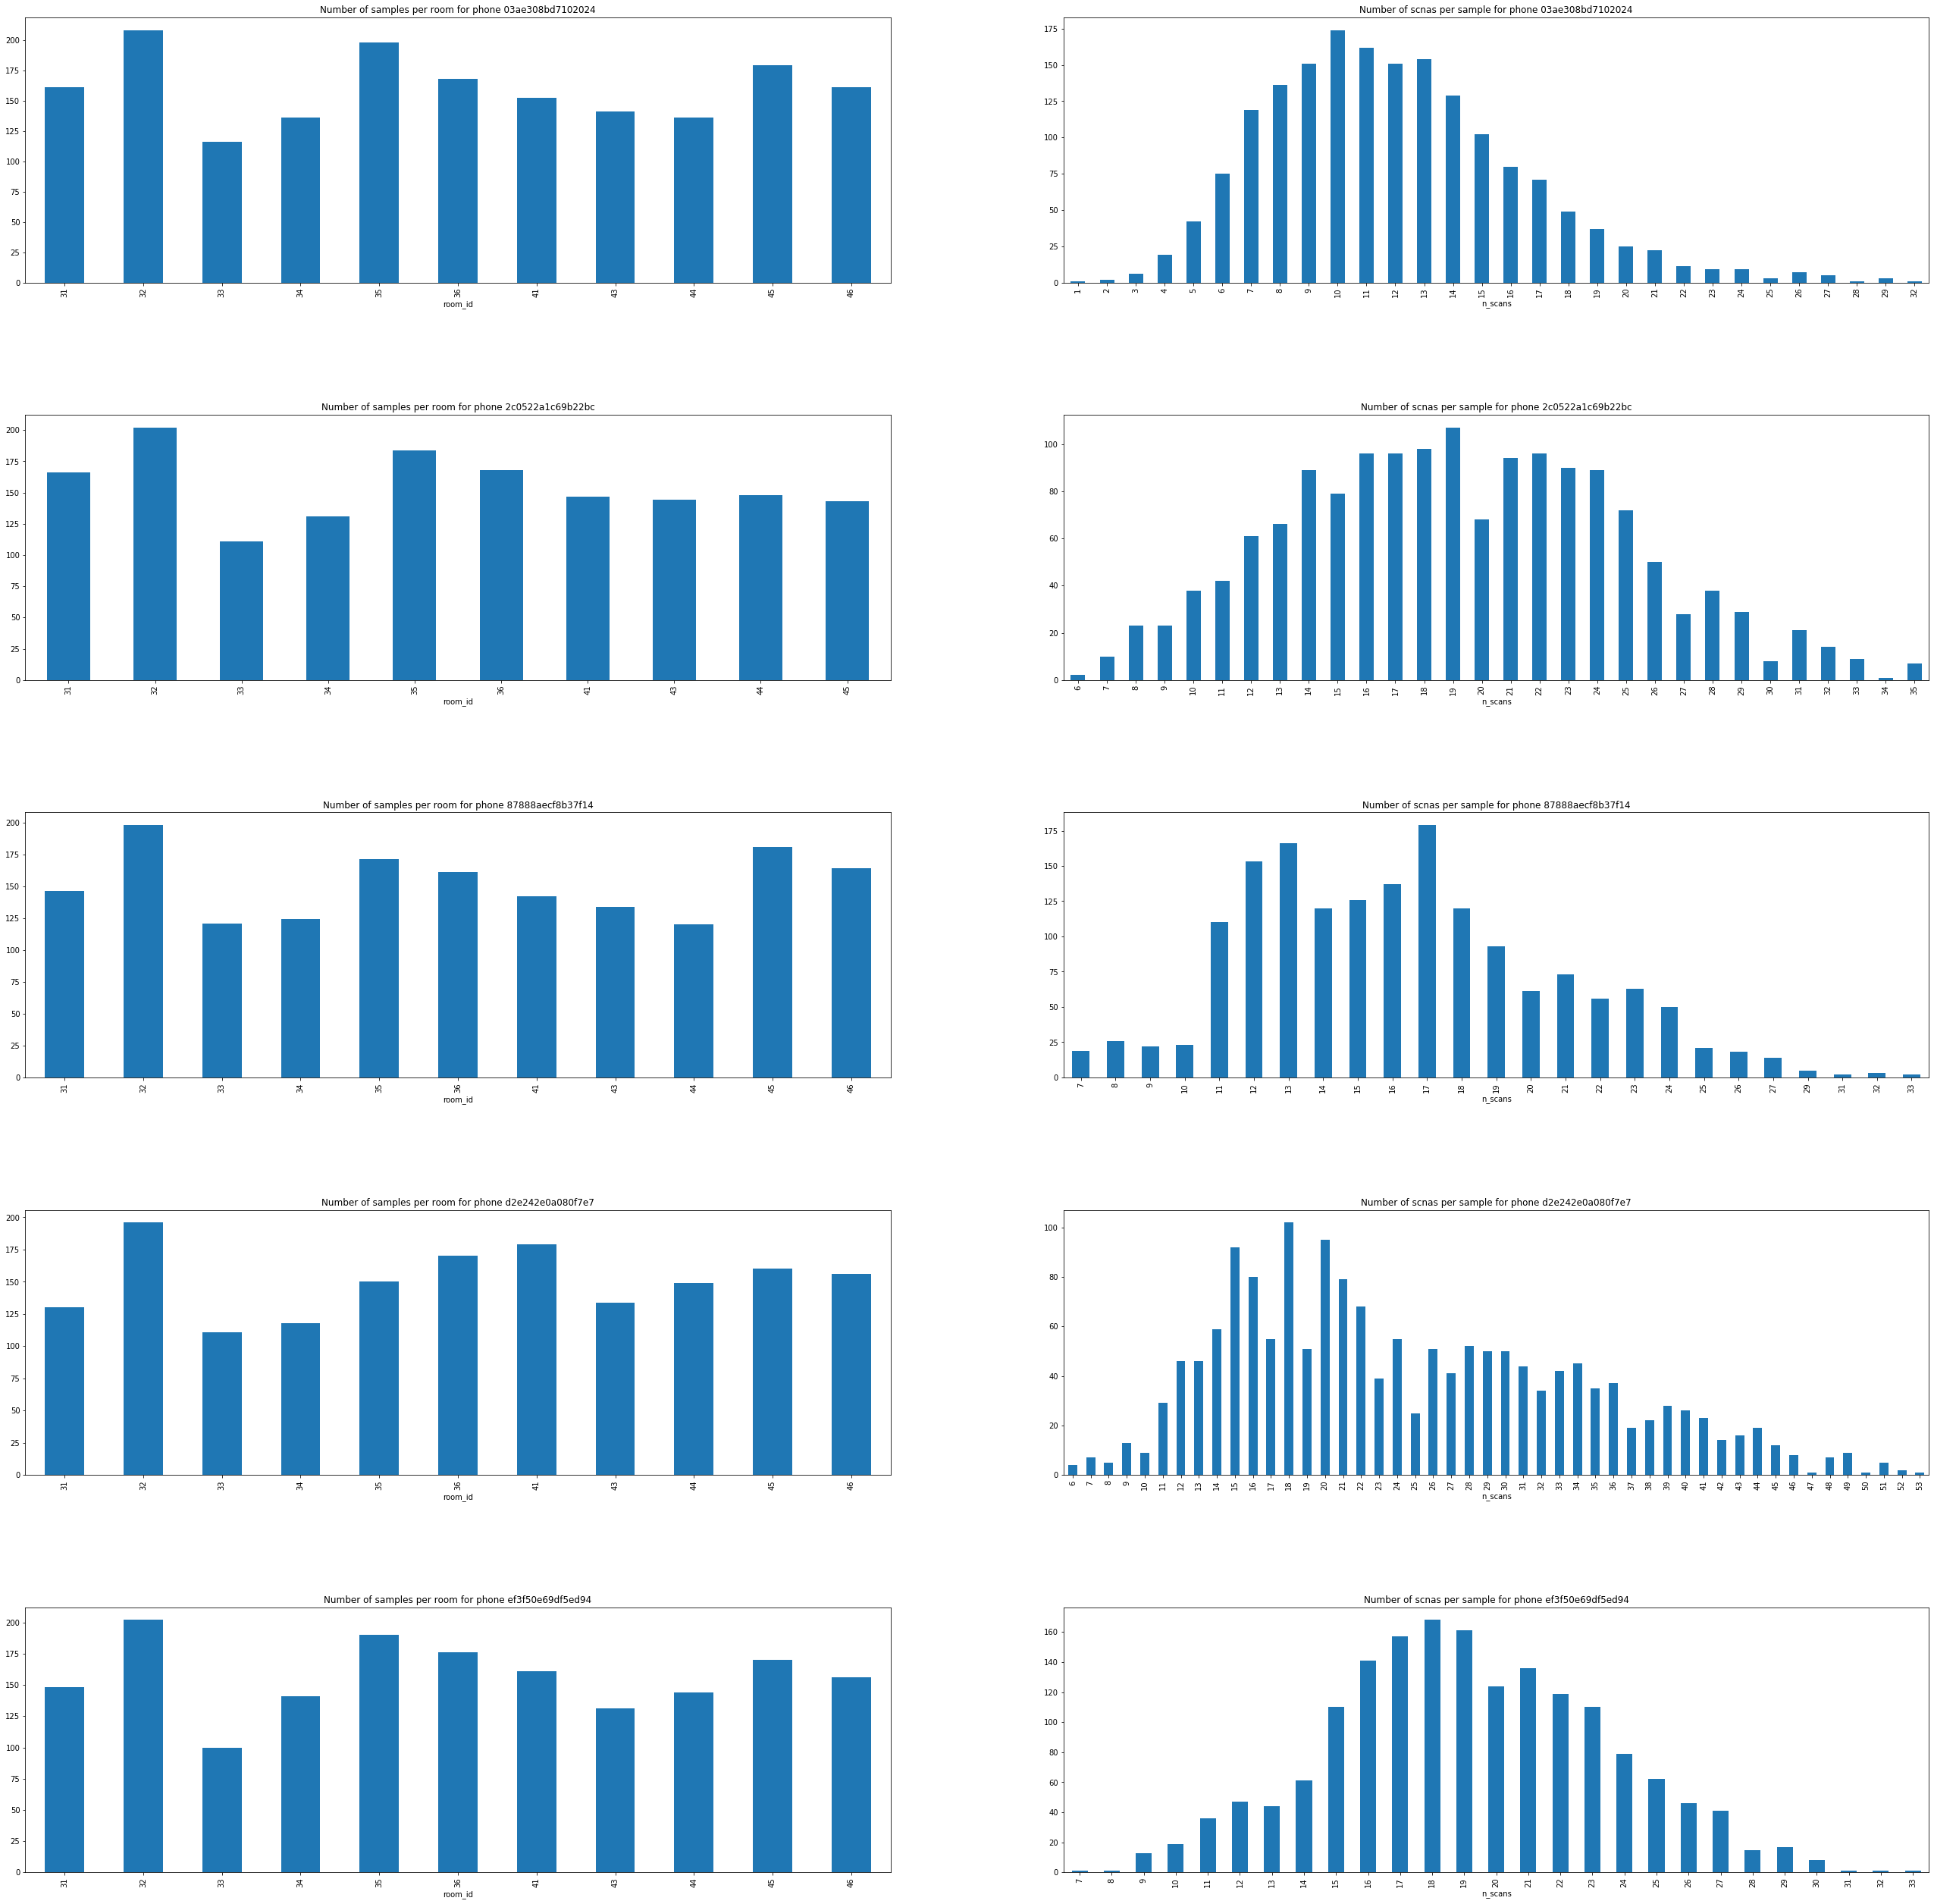

In [9]:
plt.figure(figsize=(45, 45))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.5)

i=1
for imei in imeis:
    plt.subplot(len(imeis),2,i)
    plt.title(f'Number of samples per room for phone {imei}')
    scans_df[scans_df['imei']==imei].groupby('room_id').size().plot.bar()
    plt.subplot(len(imeis),2,i+1)
    plt.title(f'Number of scnas per sample for phone {imei}')
    scans_df[scans_df['imei']==imei].groupby('n_scans').size().plot.bar()
    i+=2
plt.savefig(path+"\\scans_and_smaple_per_room_for_each_phone.jpg")

## Room prediction for each phone separately

In [10]:
#results list
results = []

nan_fill_value = -200

for imei in imeis:
    #train test split by imei:
    train = scans_df[scans_df['imei']!=imei]
    test = scans_df[scans_df['imei']==imei]
    
    X_train = train.drop(['imei', 'room_id'],axis=1).fillna(nan_fill_value)
    X_test = test.drop(['imei', 'room_id'],axis=1).fillna(nan_fill_value)
    y_train = train['room_id']
    y_test = test['room_id']
    
    #model selection:
    
#     model = KNeighborsClassifier(n_neighbors=30, weights='distance')
#     model = KNeighborsClassifier()
    model = RandomForestClassifier(random_state=1)
    
    #training model
    model_fitted = model.fit(X_train,y_train)
    y_pred = model_fitted.predict(X_test)
    
    #add the result to list
    results.append([y_test, y_pred])

In [11]:
#write the results to log file in output dir

date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
f = open(path + "\\" + date_time + '_results.txt','w')
for i in range(len(imeis)):
    f.write(f"Prediction results for phone : {imeis[i]} \n\n")
    f.write(classification_report(results[i][0],results[i][1]))
    f.write(f" \n Confusion matrix : \n")
    f.write(str(confusion_matrix(results[i][0],results[i][1]))+"\n\n")
    f.write("Accuracy Score : " + str(accuracy_score(results[i][0],results[i][1]))+"\n")
    f.write("f1 Score : " + str(f1_score(results[i][0],results[i][1],pos_label='positive',average='macro'))+"\n")
    f.write("MCC Score : " + str(matthews_corrcoef(results[i][0],results[i][1]))+"\n")
    f.write("\n______________________________________________________\n\n")
f.close()